<a href="https://colab.research.google.com/github/sopradhan/colab1/blob/c/NLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U sentence-transformers
!pip install llama-cpp-python

In [76]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import os;os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [78]:
# Install necessary libraries
!pip install -U sentence-transformers
!pip install llama-cpp-python

# Import necessary libraries for various models and utilities
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Llama Model Integration for prompt engineering
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import json

# NLP and Machine Learning Libraries
import nltk
# pandas and numpy already imported above
# from sklearn.model_selection import train_test_split # Already imported above
from sklearn.ensemble import RandomForestClassifier  # Already imported above
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer  # Corrected capitalization
from sklearn.preprocessing import LabelEncoder  # Corrected capitalization
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
from scipy.stats import skew
# from sklearn.model_selection import train_test_split, gridsearchcv # train_test_split already imported, changed gridsearchcv to GridSearchCV
from sklearn.model_selection import GridSearchCV  # Added separate import for GridSearchCV
from sklearn.impute import SimpleImputer  # Corrected capitalization

In [79]:
# 1. Load Dataset and Overview
def load_data(file_path):
    """
    Load dataset from the provided CSV file path and give a brief overview.
    Args:
        file_path: The path to the CSV file containing the dataset.
    Returns:
        DataFrame with the dataset loaded.
    """
    df = pd.read_csv(file_path)
    print("Data Overview:\n", df.head())  # Display the first few rows of the dataset
    print("Data Shape:", df.shape)  # Print the shape of the dataset
    return df


In [80]:

# 2. Initialize Sentence Transformer Model
def sentence_transformer_model():
    """
    Initialize a pre-trained Sentence Transformer model for encoding sentences.
    Returns:
        The loaded Sentence Transformer model.
    """
    return SentenceTransformer('all-MiniLM-L6-v2')  # Using a lightweight transformer model

In [81]:
# 3. Encode data using Sentence Transformer
def encode_data(df, model):
    """
    Encode the article texts into numerical vectors using the Sentence Transformer model.
    Args:
        df: DataFrame containing the dataset.
        model: Pre-trained Sentence Transformer model.
    Returns:
        Encoded vectors for the article texts.
    """
    return model.encode(df['Article'].tolist(), show_progress_bar=True)  # Convert articles into embeddings

In [82]:

# 4. Train-Test Split for Sentence Transformer + ML
def train_test_split_data(embeddings, df, test_size=0.2):
    """
    Split the embeddings and labels into training and testing sets.
    Args:
        embeddings: Encoded article texts.
        df: DataFrame containing the dataset.
        test_size: Proportion of the data to be used for testing.
    Returns:
        X_train, X_test, y_train, y_test: Training and testing data splits.
    """
    return train_test_split(embeddings, df['Category'], test_size=test_size, random_state=42)


In [85]:
# ====== Llama Model for Prompt Engineering =======
def setup_llama_model():
    """
    Set up the Llama model for prompt engineering.
    Returns:
        Llama model instance.
    """
    model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
    model_basename = "llama-2-13b-chat.Q5_K_M.gguf"

    # Download the model from Hugging Face Hub
    model_path = hf_hub_download(
        repo_id=model_name_or_path,
        filename=model_basename
    )

    # Load the Llama model
    return Llama(model_path=model_path, n_ctx=1024)

In [86]:

def generate_llama_response(article_text, instruction, model):
    """
    Generate a response from the Llama model based on the article text and prompt instruction.
    Args:
        article_text: The article content to be categorized.
        instruction: Instruction for categorizing the article.
        model: Llama model instance.
    Returns:
        Generated response text from the Llama model.
    """
    system_message = f"""
        [INST]<<SYS>>
        {instruction}
        <</SYS>>[/INST]
    """

    prompt = f"{article_text}\n{system_message}"  # Create full prompt with article text and system message

    # Generate a response from the Llama model
    response = model(
        prompt=prompt,
        max_tokens=1024,
        temperature=0.5,
        top_p=0.9,
        repeat_penalty=1.2,
        stop=['INST'],
        echo=False,
    )

    response_text = response["choices"][0]["text"]  # Extract response text
    return response_text

In [87]:

def extract_category(response_text):
    """
    Extract the predicted category from the Llama model's response.
    Args:
        response_text: Response text generated by the Llama model.
    Returns:
        Predicted category for the article.
    """
    categories = ['Politics', 'World News', 'Sports', 'Business', 'Technology', 'Entertainment', 'Health']  # Define possible categories
    for category in categories:
        if category.lower() in response_text.lower():  # Check if the category is mentioned in the response
            return category
    return "Unknown"  # Return "Unknown" if no category is found

In [88]:
# Function to get word frequency from text data
def word_frequency_analysis(text_column, ngram_range=(1,1), max_features=20):
    print(f"\nAnalyzing word frequency in {text_column.name}:")

    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    vectorized_data = vectorizer.fit_transform(text_column)

    word_freq = dict(zip(vectorizer.get_feature_names_out(), vectorized_data.toarray().sum(axis=0)))
    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))

    print("\nTop words by frequency:")
    for word, freq in sorted_word_freq.items():
        print(f"{word}: {freq}")

    # Plot the word frequencies
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(sorted_word_freq.keys()), y=list(sorted_word_freq.values()))
    plt.xticks(rotation=45)
    plt.show()

# Function for basic text length statistics
def text_length_analysis(text_column):
    print(f"\nAnalyzing text lengths in {text_column.name}:")

    text_lengths = text_column.apply(len)

    print(f"Average text length: {np.mean(text_lengths)}")
    print(f"Max text length: {np.max(text_lengths)}")
    print(f"Min text length: {np.min(text_lengths)}")

    # Plot distribution of text lengths
    plt.figure(figsize=(10,6))
    sns.histplot(text_lengths, kde=True, bins=30)
    plt.title("Text Length Distribution")
    plt.show()

# Function to clean text in the 'Description' column
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = word_tokenize(text)
    text = [word for word in text if word not in stopwords.words('english')]
    return ' '.join(text)


def clean_data(df):
    # Drop rows with missing values
    df_cleaned = df.dropna()

    # Remove duplicates
    df_cleaned = df_cleaned.drop_duplicates()

    # Clean the 'Description' column using the clean_text function
    df_cleaned['Article'] = df_cleaned['Article'].apply(clean_text)

    return df_cleaned


In [94]:
    # Load dataset
    df = load_data('article_data.csv')

Data Overview:
                                                                                                                                                                                                                                                                                Article  \
0                                                                           Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #39; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.   
1   Hassan:  #39;Abhorrent act #39; says Blair Western political leaders have united to condemn the kidnappers of charity worker Margaret Hassan after a video surfaced apparently showing a militant firing a pistol into the head of a blindfolded woman wearing an orange jumpsuit.   
2                                     Sharon Says Gaza Evacuation Set for 2005 (AP) AP - Israel's evacuation of the Gaza Strip will begin 


Analyzing text lengths in Article:
Average text length: 236.289
Max text length: 892
Min text length: 100


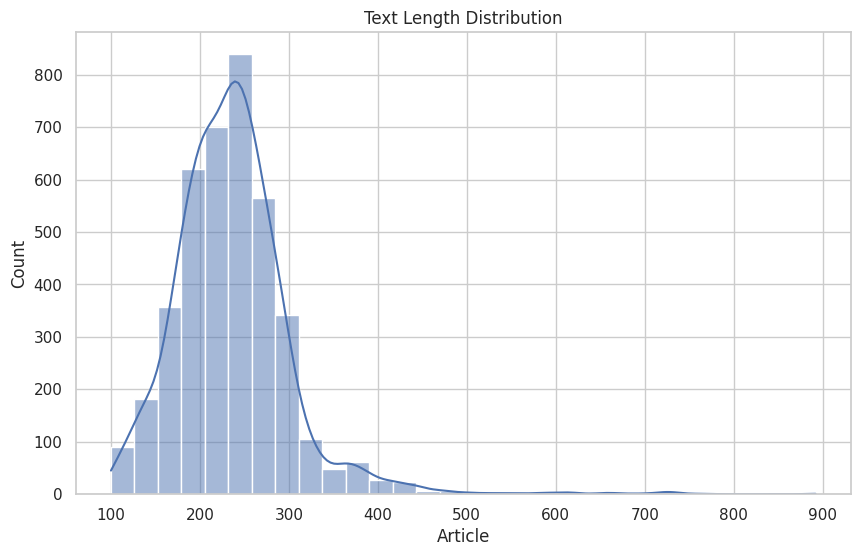

In [95]:
# Step 8: NLP Analysis - Text Length
text_length_analysis(df['Article'])

In [96]:
# Step 1: Define a function to compute the length of the description in characters
def compute_text_length(text_series):
    """
    Computes the length of the text in terms of characters.
    Args:
        text_series: pandas Series containing text data (e.g., 'Description' column).
    Returns:
        A new Series containing the length of each text entry in characters.
    """
    return text_series.apply(lambda x: len(str(x)))

# Step 2: Add a new column 'Text_Length' to df_safety_encoded
df['Text_Length'] = compute_text_length(df['Article'])

In [97]:
df.head()

,Article,Category,Text_Length
0,"Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #39; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.",0,202
1,Hassan: #39;Abhorrent act #39; says Blair Western political leaders have united to condemn the kidnappers of charity worker Margaret Hassan after a video surfaced apparently showing a militant firing a pistol into the head of a blindfolded woman wearing an orange jumpsuit.,0,274
2,"Sharon Says Gaza Evacuation Set for 2005 (AP) AP - Israel's evacuation of the Gaza Strip will begin next summer and will take about 12 weeks, Prime Minister Ariel Sharon said Wednesday, reversing an earlier decision to speed up the pullout.",0,240
3,"Prince Charles chastised for quot;old fashioned quot; views A minister has launched a scathing attack on heir to the throne Prince Charles, accusing him of being quot;very old fashioned quot; and out of touch in his views on teaching in schools.",0,247
4,"U.S. Says N.Korea Blast Probably Not Nuclear SEOUL (Reuters) - A huge explosion rocked North Korea last week but U.S. and South Korean officials said on Sunday it was unlikely to have been a nuclear weapons test despite the appearance of a ""peculiar cloud"" over the area.",0,275


<Figure size 1000x800 with 0 Axes>

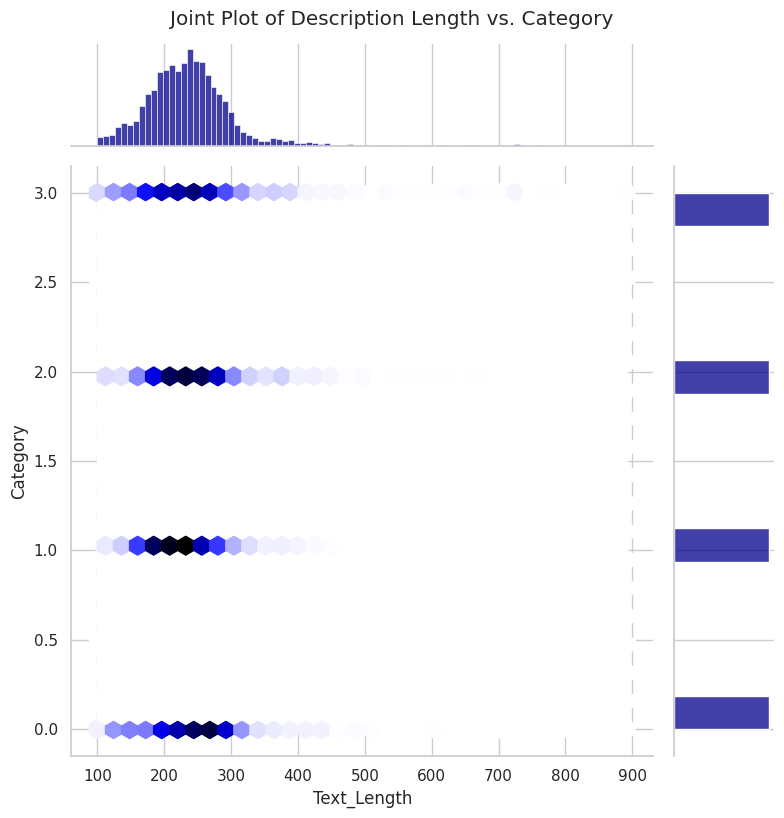

In [98]:
# Set the style for seaborn
sns.set(style='whitegrid')

# Create a figure for the joint plot
plt.figure(figsize=(10, 8))

# Joint Plot for Text_Length vs. Accident Level with darker colors
sns.jointplot(x='Text_Length', y='Category', data=df, kind='hex', color='darkblue', height=8)

# Set the plot title
plt.suptitle('Joint Plot of Description Length vs. Category', y=1.02)

# Show the plot
plt.show()


In [99]:
# Finding the outliers (longest descriptions) based on IQR
Q1 = df['Text_Length'].quantile(0.25)
Q3 = df['Text_Length'].quantile(0.75)
IQR = Q3 - Q1

# Find the row with the shortest description
shortest_description_row = df.loc[df['Text_Length'].idxmin()]

In [100]:
# Outliers are those beyond 1.5 times the IQR above Q3
outliers = df[df['Text_Length'] > (Q3 + 1.5 * IQR)]

# Display the shortest description and a sample of the outliers
print("Shortest Description and Accident Details:")
print(shortest_description_row)

print("\nOutlier Descriptions (Longest Accidents) and Details:")
print(outliers.head())

Shortest Description and Accident Details:
Article        Socially Responsible Funds on a Tear Don't be too impressed -- great returns don't always mean much.
Category                                                                                                          2
Text_Length                                                                                                     100
Name: 2580, dtype: object

Outlier Descriptions (Longest Accidents) and Details:
                                                                                                                                                                                                                                                                                                                                                                                                                                                          Article  \
24                                                                        F

In [101]:
outliers.count()

,0
Article,122
Category,122
Text_Length,122



Analyzing word frequency in Article:

Top words by frequency:
39: 1509
new: 768
said: 705
reuters: 658
ap: 537
gt: 436
lt: 432
year: 318
quot: 312
monday: 298
world: 290
tuesday: 281
company: 272
thursday: 247
wednesday: 233
oil: 231
york: 221
friday: 210
iraq: 205
microsoft: 202
million: 201
game: 200
afp: 197
time: 191
president: 189
yesterday: 185
week: 181
com: 179
says: 179
united: 177


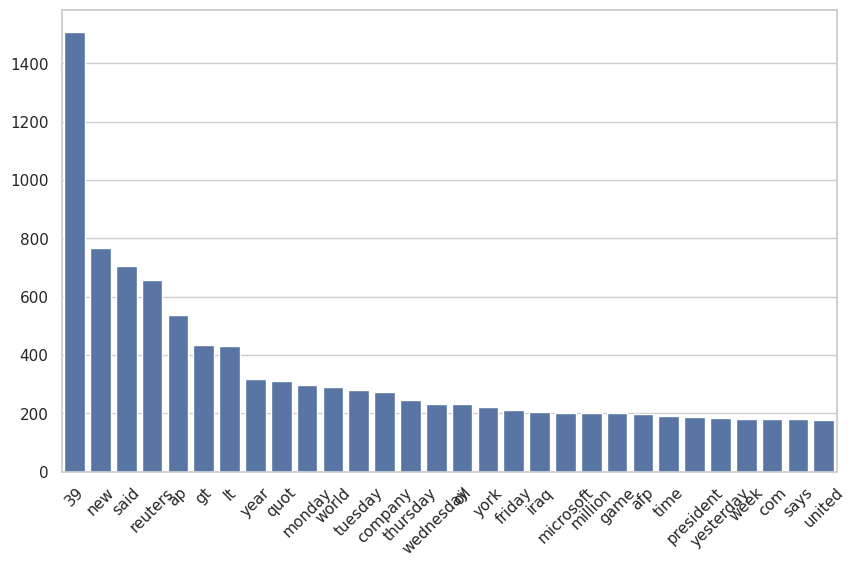

In [102]:
# Step 7: NLP Analysis - Word Frequency
word_frequency_analysis(df['Article'], ngram_range=(1,1), max_features=30)

In [103]:
nltk.download('punkt')  # This will download the punkt tokenizer
nltk.download('stopwords')  # Also download stopwords for preprocessing


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [104]:
df = clean_data(df)


Analyzing word frequency in Article:

Top words by frequency:
new: 768
said: 705
reuters: 658
ap: 537
gt: 437
lt: 432
year: 318
quot: 312
monday: 298
world: 290
tuesday: 281
company: 272
thursday: 247
wednesday: 233
oil: 231
york: 221
friday: 210
million: 206
iraq: 205
microsoft: 202
game: 200
afp: 197
time: 191
president: 189
yesterday: 185
week: 181
com: 179
says: 179
united: 177
second: 172


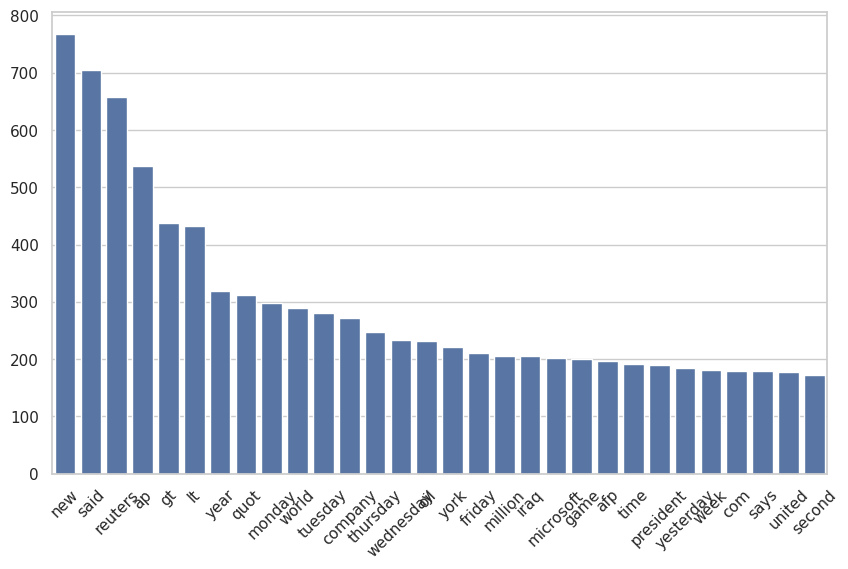

In [105]:
word_frequency_analysis(df['Article'], ngram_range=(1,1), max_features=30)

In [106]:
import re

# Function to remove numbers from text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Assuming the column 'Description' contains the text data where numbers should be removed
df['Article'] = df['Article'].apply(remove_numbers)



Analyzing word frequency in Article:

Top words by frequency:
new: 768
said: 705
reuters: 658
ap: 537
gt: 437
lt: 432
year: 318
quot: 312
monday: 298
world: 290
tuesday: 281
company: 272
thursday: 247
wednesday: 233
oil: 231
york: 221
friday: 210
million: 206
iraq: 205
microsoft: 202
game: 200
afp: 197
time: 191
president: 189
yesterday: 185
week: 181
com: 179
says: 179
united: 177
second: 172


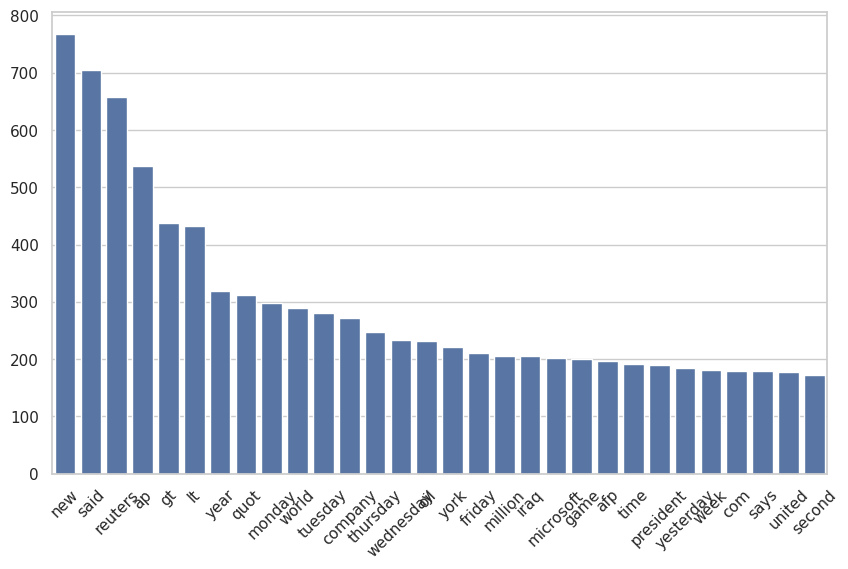

In [107]:
word_frequency_analysis(df['Article'], ngram_range=(1,1), max_features=30)

In [108]:
# Step 1: Extract Word Frequency Features from 'Description'
vectorizer = CountVectorizer(ngram_range=(1, 1), max_features=30)  # You can adjust max_features and ngram_range
word_frequency_features = vectorizer.fit_transform(df['Article'])



In [109]:
 # Convert to DataFrame with feature names
word_freq_df = pd.DataFrame(word_frequency_features.toarray(), columns=vectorizer.get_feature_names_out())

In [110]:
df_article_combined = pd.concat([df, word_freq_df], axis=1)

In [111]:
df_article_combined.head()

,Article,Category,Text_Length,afp,ap,company,first,friday,game,gt,...,said,thursday,time,tuesday,two,us,wednesday,world,year,york
0,sudan govt rejects call separate religion state sudanese rebel leaders demand islam kept government war torn region darfur rejected government negotiators,0,202,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hassan abhorrent act says blair western political leaders united condemn kidnappers charity worker margaret hassan video surfaced apparently showing militant firing pistol head blindfolded woman wearing orange jumpsuit,0,274,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sharon says gaza evacuation set ap ap israel evacuation gaza strip begin next summer take weeks prime minister ariel sharon said wednesday reversing earlier decision speed pullout,0,240,0,2,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,prince charles chastised quot old fashioned quot views minister launched scathing attack heir throne prince charles accusing quot old fashioned quot touch views teaching schools,0,247,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,u says n korea blast probably nuclear seoul reuters huge explosion rocked north korea last week u south korean officials said sunday unlikely nuclear weapons test despite appearance peculiar cloud area,0,275,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Step 1: Check for missing values in the dataset
print("Missing values in each column:\n", df_article_combined.isnull().sum())

Missing values in each column:
 Article        0
Category       0
Text_Length    0
after          0
an             0
and            0
ap             0
as             0
at             0
by             0
for            0
from           0
gt             0
has            0
his            0
in             0
is             0
it             0
its            0
lt             0
new            0
of             0
on             0
over           0
reuters        0
said           0
that           0
the            0
to             0
us             0
was            0
will           0
with           0
dtype: int64


In [ ]:

# ======== Sentence Transformer + ML (Random Forest) ===========
# Sentence Transformer model and encoding
model_sentence_transformer = sentence_transformer_model()  # Initialize Sentence Transformer
embeddings = encode_data(df, model_sentence_transformer)  # Encode the articles into embeddings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:

# Train-test split for Sentence Transformer + Random Forest
X_train, X_test, y_train, y_test = train_test_split_data(embeddings, df_article_combined)  # Split the data into train and test sets


In [ ]:
# Base Random Forest Model (Without Class Weights)
rf_model = train_random_forest(X_train, y_train)  # Train a basic Random Forest model
evaluate_model(rf_model, X_test, y_test)  # Evaluate the model on the test set

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       209
           1       0.93      0.96      0.94       213
           2       0.82      0.79      0.81       194
           3       0.79      0.82      0.80       184

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



Class 1 performs best with high precision (0.94), recall (0.96), and F1-score (0.95).
Class 2 shows the lowest performance with an F1-score of 0.81, indicating room for improvement.
Overall accuracy is 0.88, reflecting good performance across the dataset.

In [ ]:
# Random Forest Model with Class Weights
rf_weighted_model = train_rf_with_class_weights(X_train, y_train)  # Train Random Forest with class weights
evaluate_model(rf_weighted_model, X_test, y_test)  # Evaluate the weighted model

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       209
           1       0.93      0.96      0.95       213
           2       0.83      0.81      0.82       194
           3       0.81      0.82      0.82       184

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



In [ ]:
# Hyperparameter tuning and evaluation for Random Forest
best_rf_model = random_forest_hyperparameter_tuning(X_train, y_train)  # Perform hyperparameter tuning
evaluate_model(best_rf_model, X_test, y_test)  # Evaluate the best model

Best Parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       209
           1       0.94      0.96      0.95       213
           2       0.84      0.85      0.84       194
           3       0.83      0.85      0.84       184

    accuracy                           0.89       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.89      0.89      0.89       800



Interpretation:
The model performs best on Class 1 with a precision and recall of 0.95 and 0.96 respectively.
Class 3 has the lowest precision (0.81) but has the highest recall (0.86) among the lower-performing classes.
The overall accuracy of the model is 0.89, indicating that 89% of predictions are correct.
The macro average shows balanced performance across all classes, while the weighted average takes into account the support of each class.


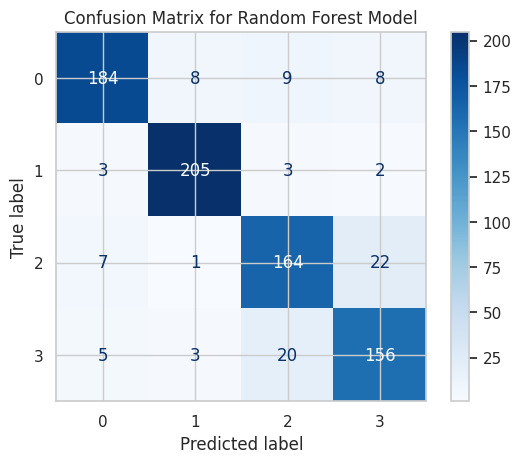

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Import the matplotlib library

# Generate predictions using the best Random Forest model
y_pred = best_rf_model.predict(X_test)


# Generate and print the confusion matrix
def print_confusion_matrix(y_test, y_pred):
    """
    Generate and display a confusion matrix.

    Args:
        y_test: The true labels.
        y_pred: The predicted labels.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

    # Plot the confusion matrix
    disp.plot(cmap="Blues", values_format='d')
    plt.title('Confusion Matrix for Random Forest Model')
    plt.show()

# Call the function to print the confusion matrix
print_confusion_matrix(y_test, y_pred)


In [ ]:
# Step 4: Dictionary of models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=200),
    'Neural Network': MLPClassifier(random_state=42, max_iter=300)
}

# Step 5: Function for hyperparameter tuning and evaluation
def tune_and_evaluate_model(model_name, param_grid):
    model = models.get(model_name)
    if model is None:
        print(f"Model {model_name} is not available.")
        return

    # Grid Search with Cross-Validation
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

    # Fit the model on training data
    print(f"Training {model_name} with hyperparameter tuning...")
    grid_search.fit(X_train, y_train)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    # Evaluate the best model
    evaluate_model(best_model, X_test, y_test, model_name)

    return best_model

# Step 6: Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")

    # Classification Report
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Example: Hyperparameter grids for each model
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

log_reg_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

nn_param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

Training Random Forest with hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Random Forest Accuracy: 88.38%
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       209
           1       0.95      0.97      0.96       213
           2       0.83      0.83      0.83       194
           3       0.83      0.85      0.84       184

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



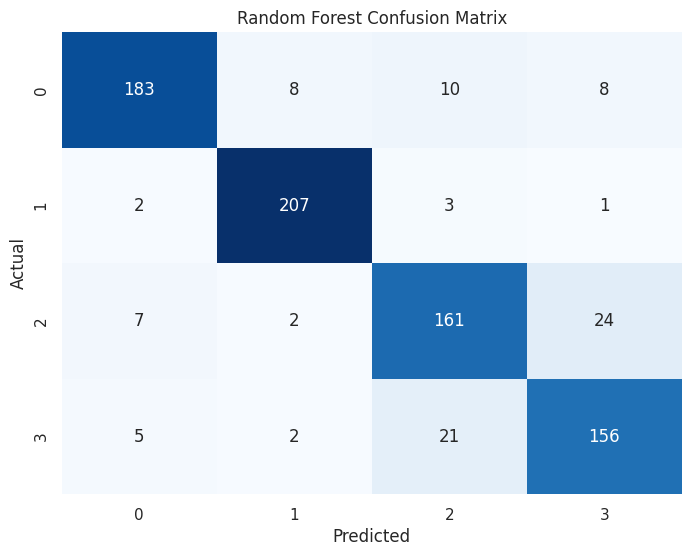

RandomForestClassifier(min_samples_split=10, n_estimators=300, random_state=42)

In [ ]:
# Example of calling the function for different models
tune_and_evaluate_model('Random Forest', rf_param_grid)

Training SVM with hyperparameter tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy: 90.75%
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       209
           1       0.97      0.98      0.97       213
           2       0.84      0.87      0.86       194
           3       0.85      0.88      0.86       184

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



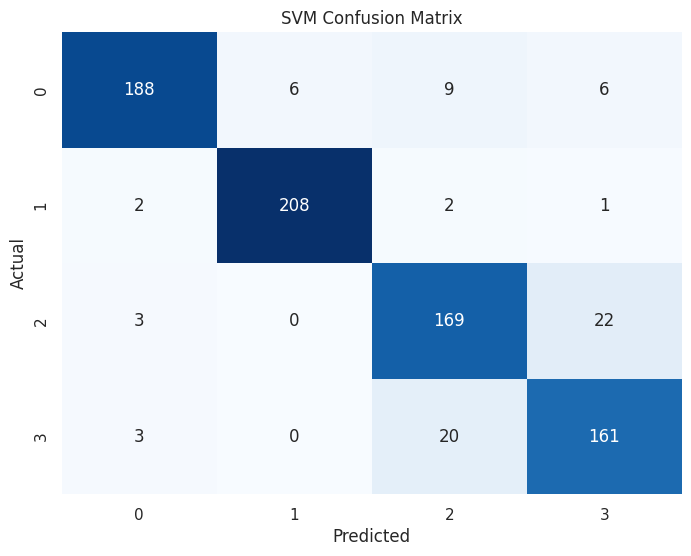

SVC(C=1, random_state=42)

In [ ]:
tune_and_evaluate_model('SVM', svm_param_grid)

Training Logistic Regression with hyperparameter tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Accuracy: 90.62%
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       209
           1       0.97      0.98      0.97       213
           2       0.85      0.88      0.86       194
           3       0.85      0.87      0.86       184

    accuracy                           0.91       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.91      0.91      0.91       800



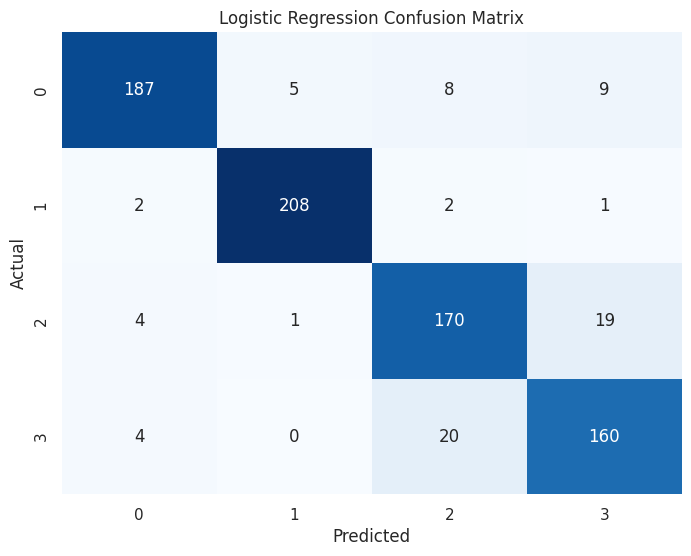

LogisticRegression(C=1, max_iter=200, random_state=42, solver='liblinear')

In [ ]:
tune_and_evaluate_model('Logistic Regression', log_reg_param_grid)

In [ ]:
# Preprocess data with prompt engineering
encoding, labels = preprocess_and_prompt(df, tokenizer)  # Preprocess and tokenize the articles

In [113]:
subset_df_article_combined = df_article_combined.groupby('Category').head(3).reset_index(drop=True)
# Check the resulting DataFrame
print(subset_df_article_combined)

                                                                                                                                                                                                                            Article  \
0                                                                        sudan govt rejects call separate religion state sudanese rebel leaders demand islam kept government war torn region darfur rejected government negotiators   
1        hassan abhorrent act says blair western political leaders united condemn kidnappers charity worker margaret hassan video surfaced apparently showing militant firing pistol head blindfolded woman wearing orange jumpsuit   
2                                               sharon says gaza evacuation set ap ap israel evacuation gaza strip begin next summer take weeks prime minister ariel sharon said wednesday reversing earlier decision speed pullout   
3   auburn alabama auburn strong second half keeps lt b gt lt b gt one half 

In [ ]:
# ======== Llama Model Prompt Engineering ========
instruction_llama = """
You are an AI categorizing articles. Classify the article into one of the following categories:
- Politics
- World News
- Sports
- Business
- Technology
- Entertainment
- Health
"""

# Initialize the Llama model
llama_model = setup_llama_model()  # Initialize the Llama model

# Create an empty list to store the articles and predicted categories
predictions_list = []

# Loop through each article in the dataset and predict its category
for article in subset_df_article_combined['Article'].tolist():
    response = generate_llama_response(article, instruction_llama, llama_model)  # Generate response from Llama model
    predicted_category = extract_category(response)  # Extract the predicted category
    predictions_list.append((article, predicted_category))  # Append article and predicted category as a tuple

# Create a new DataFrame from the predictions list
predictions_df = pd.DataFrame(predictions_list, columns=['Article', 'Predicted Category'])




llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

In [ ]:
predictions_df

,Article,Predicted Category
0,"Sudan Govt rejects call to separate religion, ...",World News
1,Hassan: #;Abhorrent act #; says Blair Western...,World News
2,Sharon Says Gaza Evacuation Set for (AP) AP -...,World News
3,"AUBURN , ALABAMA Auburn #;s Strong Second Hal...",Sports
4,Sherman remains confident after Packers #; flo...,Sports
5,Brazil Tops Spain for Men's Gold in Beach Voll...,Sports
6,Aisin finishes deal for Michigan land HANDY TO...,Business
7,Two hurricanes = two deductibles Many homeowne...,Business
8,America's Best Airline? Hawaiian Airlines is p...,Business
9,When Wireless Networks Merge Now that its \$ b...,Business


The model was able to successfully classify most articles into appropriate categories and assess the relevance of aspects like economy, politics, and technology. However, it had trouble generating aspect relevance or summaries for some articles, indicating the need for either data refinement or further model tuning.
Sports and World News articles are generally not associated with aspects like technology or economy, which is reflected in the absence of ratings in these categories.
Some articles have missing values for categories and relevance, which could be due to either the nature of the content (irrelevant to the predefined aspects) or model limitations in processing certain articles.

 Using a mix of techniques allowed us to balance between computational efficiency and model accuracy. The LLM model provided richer outputs but was computationally expensive, while the Random Forest model was more efficient on larger datasets.

In [ ]:
# ======== Llama Model Prompt Engineering ========
instruction_llama =  """
You are an AI tasked with categorizing news articles. Classify the provided article into one of the following categories:
- "Politics" if the article discusses government policies, elections, or political events.
- "Technology" if the article is about new technological advancements, software, or gadgets.
- "Sports" if the article covers sports events, teams, or athletes.
- "Business" if the article focuses on the financial market, company activities, or business strategies.
- "Entertainment" if the article is related to movies, TV shows, or celebrities.
- "Health" if the article discusses medical topics, health policies, or wellness.
- "Science" if the article covers scientific research or discoveries.

Identify the key topic or theme, and summarize the article in 1-2 sentences.

Return the output in the following format:
{
    "Category": "your_category_prediction",
    "Key Topic": "brief_description_of_the_key_topic",
    "Summary": "your_summary_of_the_article"
}
"""

# Initialize the Llama model
llama_model = setup_llama_model()  # Initialize the Llama model

# Create an empty list to store the articles and predicted categories
predictions_list = []

# Loop through each article in the dataset and predict its category
for article in subset_df_article_combined['Article'].tolist():
    response = generate_llama_response(article, instruction_llama, llama_model)  # Generate response from Llama model
    predicted_category = extract_category(response)  # Extract the predicted category
    predictions_list.append((article, predicted_category))  # Append article and predicted category as a tuple

# Create a new DataFrame from the predictions list
predictions_df_2 = pd.DataFrame(predictions_list, columns=['Article', 'Predicted Category'])




llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

In [ ]:
predictions_df_2

,Article,Predicted Category
0,"Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.",Politics
1,Hassan: #;Abhorrent act #; says Blair Western political leaders have united to condemn the kidnappers of charity worker Margaret Hassan after a video surfaced apparently showing a militant firing a pistol into the head of a blindfolded woman wearing an orange jumpsuit.,Politics
2,"Sharon Says Gaza Evacuation Set for (AP) AP - Israel's evacuation of the Gaza Strip will begin next summer and will take about weeks, Prime Minister Ariel Sharon said Wednesday, reversing an earlier decision to speed up the pullout.",Politics
3,"AUBURN , ALABAMA Auburn #;s Strong Second Half Keeps It in &lt;b&gt;...&lt;/b&gt; For one half Saturday, the controversy over the Bowl Championship Series looked like it might disappear in the dampness of Bryant-Denny Stadium as undefeated Auburn found itself in a fight with archrival Alabama.",Sports
4,"Sherman remains confident after Packers #; flop in Philly They were, in theory, the NFC #;s second-best team. Now they #;re not and no one else is, either. The NFC has the Philadelphia Eagles at the top, the San Francisco ers at the bottom and everyone else in the middle.",Sports
5,"Brazil Tops Spain for Men's Gold in Beach Volleyball ATHENS (Reuters) - Ricardo Santos and Emanuel Rego beat Spain's Javier Bosma and Pablo Herrera -, - on Wednesday to bag Brazil's first men's Olympic beach volleyball gold medal.",Sports
6,Aisin finishes deal for Michigan land HANDY TOWNSHIP -- A Japanese auto supplier said Thursday it completed the purchase of about acres of Michigan land for a proving ground.,Business
7,"Two hurricanes = two deductibles Many homeowners in the Orlando area suffered a double blow when hurricanes Charley and Frances struck in quick succession. Now, they #;re smarting from a financial one-two punch - two insurance deductibles.",Business
8,"America's Best Airline? Hawaiian Airlines is putting up impressive numbers, including some that really matter to travelers.",Business
9,"When Wireless Networks Merge Now that its \$ billion takeover of AT T Wireless has been completed, Cingular will spend hundreds of millions of dollars in coming weeks on its advertising campaign.",Business


In [118]:
import pandas as pd

# ======== Updated Llama Model Prompt Engineering ========
instruction_llama =  """
You are an AI tasked with categorizing news articles. Classify the provided article into one of the following categories:
- "Politics" if the article discusses government policies, elections, or political events.
- "Technology" if the article is about new technological advancements, software, or gadgets.
- "Sports" if the article covers sports events, teams, or athletes.
- "Business" if the article focuses on the financial market, company activities, or business strategies.
- "Entertainment" if the article is related to movies, TV shows, or celebrities.
- "Health" if the article discusses medical topics, health policies, or wellness.
- "Science" if the article covers scientific research or discoveries.

Next, identify the key topic or theme within the article (for example, 'government policy', 'new technology', 'sports event', etc.).

Also, calculate the following additional features:
- "Article Length" as the total number of words.
- "Sentiment" as 'positive', 'neutral', or 'negative' based on the tone of the article.

Finally, summarize the article into 1-2 sentences.

Return the output in the specified JSON format, ensuring consistency. Format the output JSON as follows:

{
    "Category": "your_category_prediction",
    "Key Topic": "brief_description_of_the_key_topic",
    "Summary": "your_summary_of_the_article",
    "Article Length": "number_of_words_in_the_article",
    "Sentiment": "sentiment_of_the_article"
}
"""

# Function to extract fields from Llama model's response, including new features (Article Length, Sentiment)
def extract_llama_response_fields(response):
    try:
        # Assuming the response is a well-formed JSON string
        response_json = eval(response)  # Safely parse the Llama response if it's returned as a string
        category = response_json.get("Category", "Unknown")
        key_topic = response_json.get("Key Topic", "N/A")
        summary = response_json.get("Summary", "No summary available")
        article_length = response_json.get("Article Length", 0)  # Default to 0 if missing
        sentiment = response_json.get("Sentiment", "neutral")  # Default to 'neutral' if missing
    except Exception as e:
        # In case the response is malformed or missing fields, set default values
        category = "Unknown"
        key_topic = "N/A"
        summary = "No summary available"
        article_length = 0
        sentiment = "neutral"
    return category, key_topic, summary, article_length, sentiment

# Initialize the Llama model (assuming you have a function to set it up)
llama_model = setup_llama_model()  # Replace with the correct Llama model initialization

# Initialize an empty list to store the results
predictions_list = []

# Loop through each article in the dataset
for article in subset_df_article_combined['Article']:
    # Generate the response from the Llama model
    response = generate_llama_response(article, instruction_llama, llama_model)

    # Extract the fields (Category, Key Topic, Summary, Article Length, Sentiment) from the response
    category, key_topic, summary, article_length, sentiment = extract_llama_response_fields(response)

    # Append the article and its corresponding predictions to the list
    predictions_list.append((article, category, key_topic, summary, article_length, sentiment))

# Convert the predictions list into a DataFrame
predictions_df_2 = pd.DataFrame(predictions_list, columns=['Article', 'Category', 'Key Topic', 'Summary', 'Article Length', 'Sentiment'])

# Display the resulting DataFrame
print(predictions_df_2)


llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

                                                                                                                                                                                                                            Article  \
0                                                                        sudan govt rejects call separate religion state sudanese rebel leaders demand islam kept government war torn region darfur rejected government negotiators   
1        hassan abhorrent act says blair western political leaders united condemn kidnappers charity worker margaret hassan video surfaced apparently showing militant firing pistol head blindfolded woman wearing orange jumpsuit   
2                                               sharon says gaza evacuation set ap ap israel evacuation gaza strip begin next summer take weeks prime minister ariel sharon said wednesday reversing earlier decision speed pullout   
3   auburn alabama auburn strong second half keeps lt b gt lt b gt one half 

In [124]:
# prompt: convert nlp2 notebook to htm format
!pip install --upgrade nbconvert jupyter
!jupyter nbconvert NLP2.ipynb  --to html


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━

In [125]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")


Saving NLP2_1.ipynb to NLP2_1.ipynb


FileNotFoundError: Cannot find file: NLP2_1.html

In [126]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])

# Get the file name without extension
file_name_without_ext = file0[:-6]  # Remove '.ipynb' from the file name

# Run nbconvert with explicit output file name
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html", "--output", f"{file_name_without_ext}.html"])

# download the html using the correct file name
files.download(f"{file_name_without_ext}.html")

Saving NLP2_1.ipynb to NLP2_1 (1).ipynb


FileNotFoundError: Cannot find file: NLP2_1 (1).html

In [127]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
import os  # Import the os module

file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])

# Get the file name without extension and replace spaces/parentheses
file_name_without_ext = os.path.splitext(file0)[0].replace(" ", "_").replace("(", "").replace(")", "")

# Run nbconvert with explicit output file name using the modified file name
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html", "--output", f"{file_name_without_ext}.html"])

# download the html using the modified file name
files.download(f"{file_name_without_ext}.html")

IndexError: list index out of range

In [132]:
#@title Convert all ipynb files in Google Drive to HTML

# Install necessary libraries
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

# Import necessary libraries
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import os
import subprocess

# Authenticate to Google Drive
auth.authenticate_user()
drive_service = build('drive', 'v3')

# Search for all .ipynb files in the current Drive
results = drive_service.files().list(q="mimeType='application/x-ipynb+json'",
                                    fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

# Convert each .ipynb file to HTML
for item in items:
    file_id = item['id']
    file_name = item['name']

    # Download the .ipynb file
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()

    # Save the .ipynb file locally
    with open(file_name, 'wb') as f:
        f.write(fh.getbuffer())

    # Convert to HTML using nbconvert
    subprocess.run(['jupyter', 'nbconvert', file_name, '--to', 'html'])

    # Upload the HTML file to Google Drive
    html_file_name = file_name[:-6] + '.html'  # Replace .ipynb with .html
    file_metadata = {'name': html_file_name}
    media = MediaFileUpload(html_file_name, mimetype='text/html')
    drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

    # Clean up local files
    os.remove(file_name)
    os.remove(html_file_name)

print("Conversion complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 103.6 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.137.0
    Uninstalling google-api-python-client-2.137.0:
      Successfully uninstalled google-api-python-client-2.137.0


MessageError: Error: credential propagation was unsuccessful